<a href="https://colab.research.google.com/github/jiyoungemma/section4_project/blob/main/Cyberbullying_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 프로젝트 목적
- SNS에 익명성을 앞세워 타인에게 악담을 쏟아 붓는 경우가 많아지고 이로 인해 미성숙한 청소년들의 피해사례가 늘어나고 있다.
- 이번 프로젝트를 통해 사이버불링을 찾아내는 모델을 만들어 사이버불링을 리트윗 등으로 퍼트리지 않고 자동적으로 숨김처리를 하거나 삭제하는 등의 방법으로 사전에 피해를 막고자 한다.

## 필요한 라이브러리

In [ ]:
!sudo pip3 install emoji

     |████████████████████████████████| 175 kB 9.0 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=31daf9ca53b1d24a40970cc96f4d877441780a8cb709150f9b5701f71c67779e
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji


In [ ]:
!pip install --upgrade matplotlib

In [ ]:
pip install wordcloud

In [ ]:
!pip install afinn # 감정사전 라이브러리

     |████████████████████████████████| 52 kB 702 kB/s 
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=a630eda4583efe600542335b17f4c334a9a12ca2a3e8346d89b859450149ba45
  Stored in directory: /root/.cache/pip/wheels/9d/16/3a/9f0953027434eab5dadf3f33ab3298fa95afa8292fcf7aba75
Successfully built afinn


In [ ]:
pip install nltk

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import re, string
import emoji
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from afinn import Afinn
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Conv1D, Dropout, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 불러오기 및 전처리

In [ ]:
tweets = pd.read_csv('/content/drive/MyDrive/project_4/cyberbullying_tweets.csv')

In [ ]:
tweets

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying
...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity
47688,Turner did not withhold his disappointment. Tu...,ethnicity
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity


In [ ]:
tweets['cyberbullying_type'].value_counts()

religion               7998
age                    7992
gender                 7973
ethnicity              7961
not_cyberbullying      7945
other_cyberbullying    7823
Name: cyberbullying_type, dtype: int64

In [ ]:
tweets = tweets.rename(columns={'tweet_text':'tweet', 'cyberbullying_type':'type'})

In [ ]:
tweets.duplicated().sum()

36

In [ ]:
tweets = tweets.drop_duplicates()

In [ ]:
#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", text) #remove emoji

stop_words = set(stopwords.words('english'))
#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#apply all
def deep_clean(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [ ]:
tweets_pro = []
for t in tweets.tweet:
  tweets_pro.append(deep_clean(t))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: 'emoji.get_emoji_regexp()' is deprecated and will be removed in version 2.0.0. If you want to remove emoji from a string, consider the method emoji.replace_emoji(str, replace='').
To hide this warning, pin/downgrade the package to 'emoji~=1.6.3'
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
tweets['tweets_pro'] = tweets_pro

In [ ]:
tweets.head()

,tweet,type,tweets_pro
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock today sunris studi...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...


In [ ]:
tweets['tweets_pro'].duplicated().sum()

3058

In [ ]:
tweets.drop_duplicates('tweets_pro', inplace=True)

In [ ]:
tweets.shape

(44598, 3)

In [ ]:
tweets.type.value_counts()

religion               7946
age                    7884
ethnicity              7744
not_cyberbullying      7637
gender                 7607
other_cyberbullying    5780
Name: type, dtype: int64

In [ ]:
# tweets length

text_len = []
for text in tweets.tweets_pro:
  length = len(text.split())
  text_len.append(length)

In [ ]:
tweets['text_len'] = text_len

In [ ]:
tweets

,tweet,type,tweets_pro,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock today sunris studi...,10
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter,9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...,8
...,...,...,...,...
47687,"Black ppl aren't expected to do anything, depe...",ethnicity,black ppl expect anyth depend anyth yet free p...,21
47688,Turner did not withhold his disappointment. Tu...,ethnicity,turner withhold turner call court abomin concl...,28
47689,I swear to God. This dumb nigger bitch. I have...,ethnicity,swear god dumb nigger bitch got bleach hair re...,13
47690,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,yea fuck rt your nigger fuck unfollow fuck dum...,10


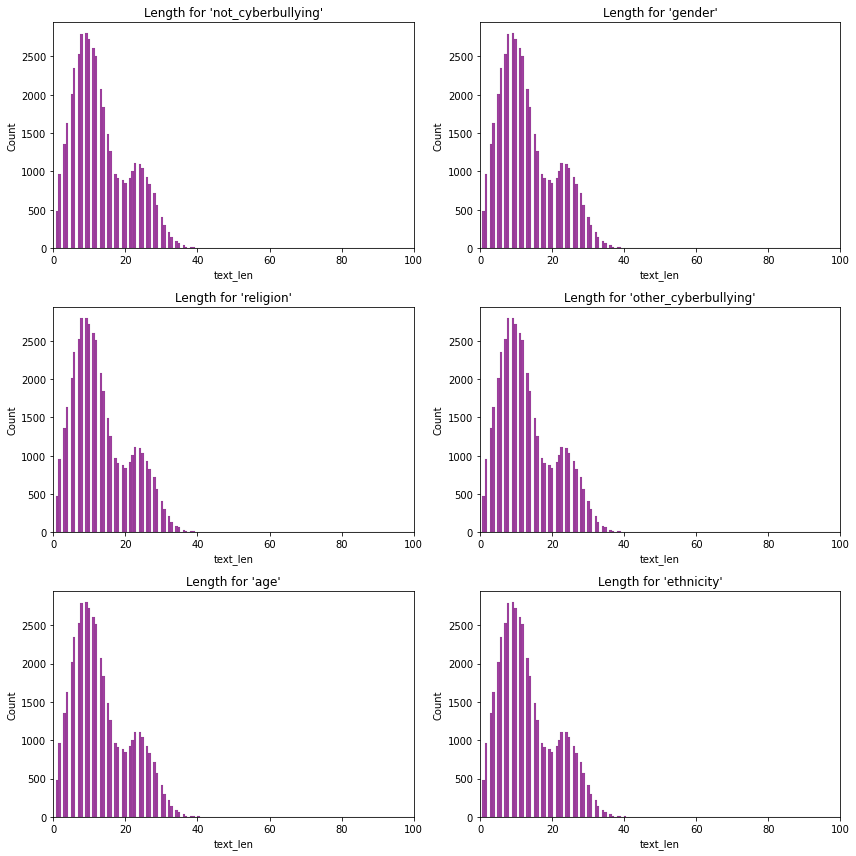

In [ ]:
all_labels = tweets['type'].unique()

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
k = 0
for i in range(3):
  for j in range(2):
    all = all_labels[k]
    tweet_len = tweets['text_len']
    sns.histplot(tweet_len, ax=ax[i,j], color ='purple')
    ax[i,j].set_title("Length for '{}'".format(all));
    ax[i,j].set_xlim(0, 100);
    plt.tight_layout();
    k+=1    

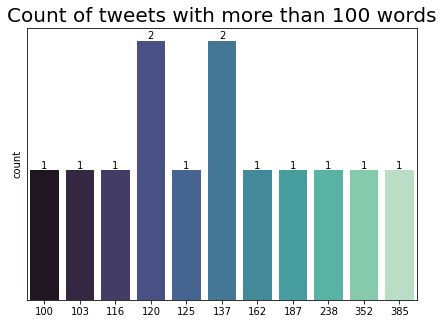

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=tweets[tweets['text_len']>=100], palette='mako')
plt.title('Count of tweets with more than 100 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

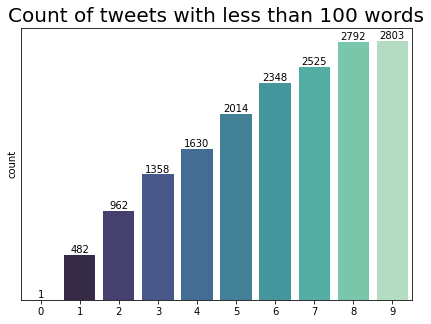

In [ ]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=tweets[tweets['text_len'] < 10], palette='mako')
plt.title('Count of tweets with less than 100 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [ ]:
# remove tweets with more than 100 words

tweets = tweets[tweets['text_len'] < 100]

In [ ]:
# remove tweets with less than 3

tweets = tweets[tweets['text_len'] > 3]

In [ ]:
tweets.shape

(41782, 4)

In [ ]:
tweets.reset_index(inplace=True)

In [ ]:
np.max(tweets['text_len'])

82

In [ ]:
tweets.sort_values(by=['text_len'], ascending=False)

,index,tweet,type,tweets_pro,text_len
22487,25411,@Sweetie_Niesha: So Im getting bullied via twi...,other_cyberbullying,im get bulli via twitter read breitbart rt lt3...,82
3889,4846,@andrea_gcav: @viviaanajim recuerdas como noso...,not_cyberbullying,recuerda como nosotra tambin eramo victima del...,79
38499,44294,@JasmineLovvee If He Dont Want You Well Fuck H...,ethnicity,dont want well fuck aint worth tear never swea...,73
22784,25939,If cats looked like frogs we'd realize what na...,other_cyberbullying,cat look like frog would realiz nasti cruel li...,71
40092,45930,"Get off ur ego trip, take off ur rose colored ...",ethnicity,get ur ego trip take ur rose color glass amp g...,45
...,...,...,...,...,...
21799,24278,"@flyfishidaho I'm not a shark, I'm the tree be...",other_cyberbullying,shark tree behind shark,4
8790,10549,@VeganStar2001 @purity95433873 When did the fi...,gender,first feminazi learn read,4
8800,10560,@DrReneeObey @GravityDynamic @rushlimbaugh He ...,gender,invent word feminazi believ,4
748,919,@98Halima @BilalIGhumman @johnnygjokaj @cdnKha...,not_cyberbullying,bloodiest histori murder islam,4


In [ ]:
#감정분석 스코어

types = tweets['type']

In [ ]:
types

0        not_cyberbullying
1        not_cyberbullying
2        not_cyberbullying
3        not_cyberbullying
4        not_cyberbullying
               ...        
41777            ethnicity
41778            ethnicity
41779            ethnicity
41780            ethnicity
41781            ethnicity
Name: type, Length: 41782, dtype: object

In [ ]:
afinn = Afinn()
for i in range(40000,40010):
  print(tweets_pro[i])
  print(afinn.score(tweets_pro[i]))
  print(types[i])

yet trump huge racist blame race anyth goe wrong blame mexican asian mostli past year refus even acknowledg black live matter movement
-7.0
ethnicity
play white kid think go back histori black basebal still call negro leagu
0.0
ethnicity
call spic white liber numer occas innoc negro
0.0
ethnicity
black woman nigger offend unless use white offend taught meant anyon disgust nasti
-12.0
ethnicity
mexican black dumb say nigger dumb fat fuck
-15.0
ethnicity
im start think low iq perhap brought 19 black peopl kill 55 injur past weekend chicago victim black black crime perhap random mug none anyth 4th juli
-9.0
ethnicity
fuck dumb ass scari ass face ass bitch say nigger everi day stupid ass hoe
-35.0
ethnicity
america fuck racist killyourself wasteoflif rt fuck obama dumb ass nigger
-23.0
ethnicity
real talk fuck boi put period everi word even capit em dumb nigger
-12.0
ethnicity
ppl sooo dumb bet littl boy birth dad would call nigger fuck yall defend
-12.0
ethnicity


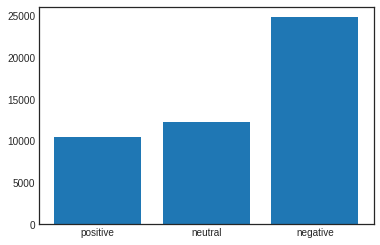

In [ ]:
plt.style.use('seaborn-white')

positive = 0
neutral = 0
negative = 0

for i in tweets_pro:
  score = afinn.score(i)
  if score > 0:
    positive += 1
  elif score == 0:
    neutral += 1
  else:
    negative += 1

plt.bar(np.arange(3), [positive, neutral, negative])
plt.xticks(np.arange(3), ['positive', 'neutral', 'negative'])
plt.show()

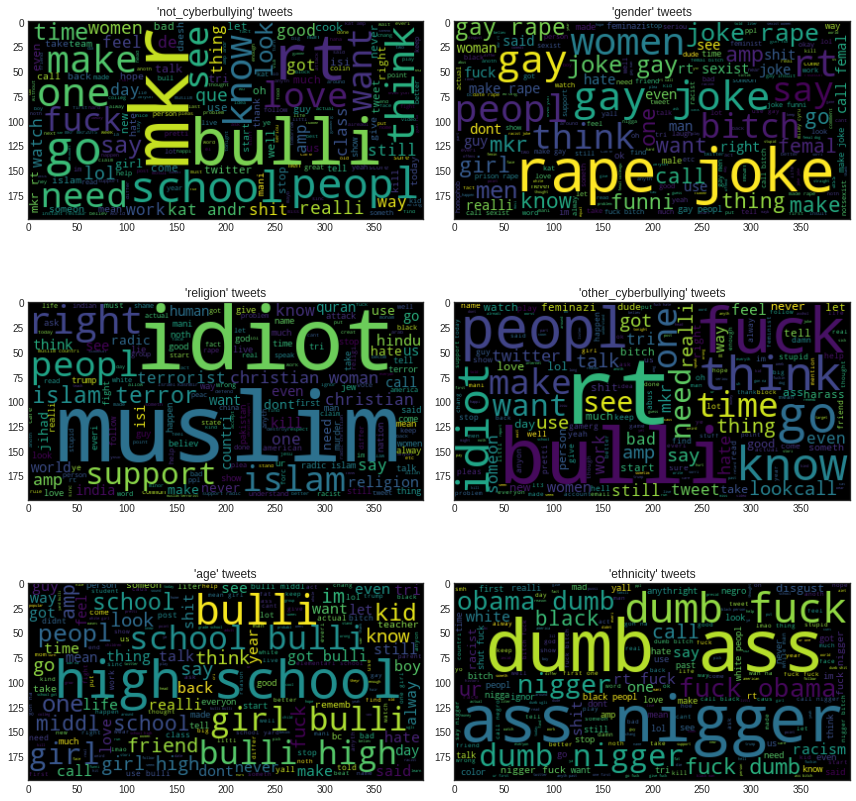

In [ ]:
# common words

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,12))
k = 0
for i in range(3):
  for j in range(2):
    all = all_labels[k]
    wordcloud = WordCloud().generate(" ".join(tweets[tweets['type']==all]['tweets_pro'].tolist()))

    ax[i,j].imshow(wordcloud, interpolation='bilinear');
    ax[i,j].set_title("'{}' tweets".format(all));
    k+=1
fig.tight_layout()

In [ ]:
tweets.drop(columns=['index'],axis=1, inplace=True)

In [ ]:
tweets

,tweet,type,tweets_pro,text_len
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandr food crapilici mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock today sunris studi...,10
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classi whore red velvet cupcak,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh p thank head concern anoth angri dude twitter,9
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretend kurdish account like islam...,8
...,...,...,...,...
41777,"Black ppl aren't expected to do anything, depe...",ethnicity,black ppl expect anyth depend anyth yet free p...,21
41778,Turner did not withhold his disappointment. Tu...,ethnicity,turner withhold turner call court abomin concl...,28
41779,I swear to God. This dumb nigger bitch. I have...,ethnicity,swear god dumb nigger bitch got bleach hair re...,13
41780,Yea fuck you RT @therealexel: IF YOURE A NIGGE...,ethnicity,yea fuck rt your nigger fuck unfollow fuck dum...,10


## 모델링

### 데이터 균형 맞추기

In [ ]:
tweets['sentiment'] = tweets['type'].replace({'religion':0, 'age':1, 'ethnicity':2, 'gender':3, 'not_cyberbullying':4, 'other_cyberbullying':5})

In [ ]:
# train, test data set split

train = tweets['tweets_pro']
test = tweets['sentiment']

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size = 0.2, stratify = test, random_state = 42)

Class=3, n=5849 (17.499%)
Class=0, n=6314 (18.890%)
Class=5, n=3735 (11.174%)
Class=2, n=6166 (18.447%)
Class=1, n=6264 (18.740%)
Class=4, n=5097 (15.249%)


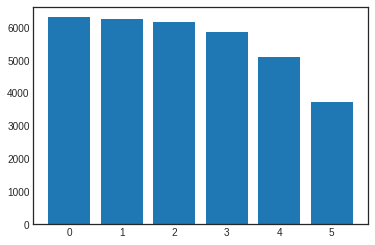

In [ ]:
# Check unbalanced data

def count_and_plot(y): 
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
    plt.bar(counter.keys(), counter.values())
    plt.show()

count_and_plot(y_train)

In [ ]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_over = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['tweet', 'sentiment']);

In [ ]:
X_train = train_over['tweet'].values
y_train = train_over['sentiment'].values

Class=3, n=6314 (16.667%)
Class=0, n=6314 (16.667%)
Class=5, n=6314 (16.667%)
Class=2, n=6314 (16.667%)
Class=1, n=6314 (16.667%)
Class=4, n=6314 (16.667%)


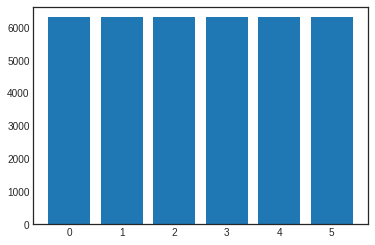

In [ ]:
count_and_plot(y_train)

In [ ]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6314],
       [   1, 6314],
       [   2, 6314],
       [   3, 6314],
       [   4, 6314],
       [   5, 6314]])

### Baseline Model

In [ ]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_tf, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

In [ ]:
sentiments = ['religion', 'age' ,'ethnicity','gender','not_bullying','other_bullying']

In [ ]:
print(classification_report(y_test, lr.predict(X_test_tf), target_names=sentiments))

                precision    recall  f1-score   support

      religion       0.96      0.93      0.95      1579
           age       0.95      0.97      0.96      1566
     ethnicity       0.97      0.98      0.98      1542
        gender       0.92      0.84      0.88      1462
  not_bullying       0.64      0.59      0.62      1274
other_bullying       0.54      0.67      0.60       934

      accuracy                           0.85      8357
     macro avg       0.83      0.83      0.83      8357
  weighted avg       0.86      0.85      0.85      8357



In [ ]:
confusion_matrix(y_test, lr.predict(X_test_tf))

array([[1476,    0,    7,    3,   71,   22],
       [   2, 1520,    0,    3,   25,   16],
       [   2,    0, 1516,    4,   11,    9],
       [   3,    4,    7, 1233,  101,  114],
       [  38,   57,   15,   40,  753,  371],
       [  12,   24,   12,   53,  208,  625]])

## RNN 모델링

- 연속적인 데이터(자연어)를 처리하기 위해 RNN모델을 사용
- 그 중 가장 보편적인 LSTM을 사용하여 기존 RNN모델에서 발생할 수 있는 기울기 소실 문제를 사전에 방지

In [ ]:
tokenizer = Tokenizer(num_words=3000)
tokenizer.fit_on_texts(X_train)

X_train_encoded = tokenizer.texts_to_sequences(X_train)
X_test_encoded = tokenizer.texts_to_sequences(X_test)

X_train_padd = pad_sequences(X_train_encoded, maxlen = 400)
X_test_padd = pad_sequences(X_test_encoded, maxlen = 400)

Epoch 1/30
592/592 - 19s - loss: 1.7826 - val_loss: 1.7726 - 19s/epoch - 33ms/step
Epoch 2/30
592/592 - 14s - loss: 1.7119 - val_loss: 1.6335 - 14s/epoch - 24ms/step
Epoch 3/30
592/592 - 14s - loss: 1.5787 - val_loss: 1.5725 - 14s/epoch - 24ms/step
Epoch 4/30
592/592 - 14s - loss: 1.5478 - val_loss: 1.5532 - 14s/epoch - 24ms/step
Epoch 5/30
592/592 - 14s - loss: 1.5063 - val_loss: 1.4774 - 14s/epoch - 24ms/step
Epoch 6/30
592/592 - 14s - loss: 1.3779 - val_loss: 1.2457 - 14s/epoch - 24ms/step
Epoch 7/30
592/592 - 14s - loss: 1.1482 - val_loss: 1.0348 - 14s/epoch - 24ms/step
Epoch 8/30
592/592 - 15s - loss: 0.9875 - val_loss: 0.9080 - 15s/epoch - 25ms/step
Epoch 9/30
592/592 - 15s - loss: 0.9136 - val_loss: 0.8010 - 15s/epoch - 25ms/step
Epoch 10/30
592/592 - 14s - loss: 0.7842 - val_loss: 0.6968 - 14s/epoch - 24ms/step
Epoch 11/30
592/592 - 15s - loss: 1.4864 - val_loss: 1.3154 - 15s/epoch - 25ms/step
Epoch 12/30
592/592 - 15s - loss: 0.9262 - val_loss: 0.8441 - 15s/epoch - 25ms/step
E

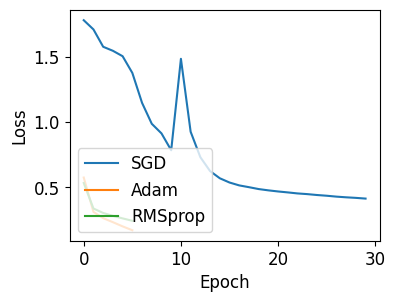

In [ ]:
# 옵티마이저 비교

plt.style.use('default')
plt.rcParams['figure.figsize'] = (4, 3)
plt.rcParams['font.size'] = 12

tf.random.set_seed(0)
model1 = Sequential()
model1.add(Embedding(20000,128))
model1.add(LSTM(128))
model1.add(Dense(6, activation='softmax'))

tf.random.set_seed(0)
model2 = tf.keras.models.clone_model(model1)

tf.random.set_seed(0)
model3 = tf.keras.models.clone_model(model1)

model1.compile(loss='sparse_categorical_crossentropy', optimizer='SGD')
model2.compile(loss='sparse_categorical_crossentropy', optimizer='Adam')
model3.compile(loss='sparse_categorical_crossentropy', optimizer='RMSprop')

history = model1.fit(X_train_padd, y_train, batch_size=64, epochs=30, verbose=2, validation_data=(X_test_padd, y_test), callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1)])
history2 = model2.fit(X_train_padd, y_train, batch_size=64, epochs=30, verbose=2, validation_data=(X_test_padd, y_test), callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1)])
history3 = model3.fit(X_train_padd, y_train, batch_size=64, epochs=30, verbose=2, validation_data=(X_test_padd, y_test), callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1)])

loss = history.history['loss']
loss2 = history2.history['loss']
loss3 = history3.history['loss']
plt.plot(loss, label='SGD')
plt.plot(loss2, label='Adam')
plt.plot(loss3, label='RMSprop')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower left')
plt.show()

In [ ]:
model = Sequential()
model.add(Embedding(20000,128))
model.add(LSTM(128))
model.add(Dense(6, activation='softmax'))

sgd = tf.keras.optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 6)                 774       
                                                                 
Total params: 2,692,358
Trainable params: 2,692,358
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(X_train_padd, y_train, batch_size=64, epochs=100, verbose=1, validation_data=(X_test_padd, y_test), callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1)])

Epoch 1/100
592/592 [==============================] - 17s 26ms/step - loss: 1.3955 - acc: 0.4389 - val_loss: 0.7323 - val_acc: 0.7256
Epoch 2/100
592/592 [==============================] - 15s 26ms/step - loss: 0.6530 - acc: 0.7396 - val_loss: 0.4649 - val_acc: 0.7960
Epoch 3/100
592/592 [==============================] - 15s 26ms/step - loss: 0.4799 - acc: 0.7948 - val_loss: 0.4140 - val_acc: 0.8259
Epoch 4/100
592/592 [==============================] - 16s 27ms/step - loss: 0.4359 - acc: 0.8145 - val_loss: 0.3933 - val_acc: 0.8347
Epoch 5/100
592/592 [==============================] - 16s 26ms/step - loss: 0.4049 - acc: 0.8321 - val_loss: 0.3792 - val_acc: 0.8447
Epoch 6/100
592/592 [==============================] - 15s 26ms/step - loss: 0.3766 - acc: 0.8490 - val_loss: 0.3752 - val_acc: 0.8503
Epoch 7/100
592/592 [==============================] - 15s 26ms/step - loss: 0.3557 - acc: 0.8585 - val_loss: 0.3688 - val_acc: 0.8513
Epoch 8/100
592/592 [==============================] - 

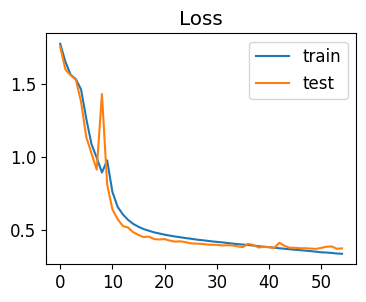

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

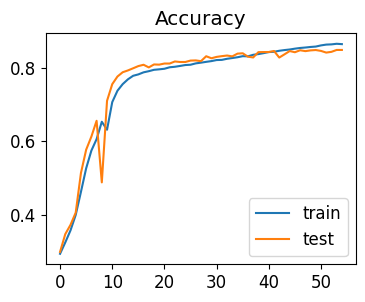

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [ ]:
model.evaluate(X_test_padd, y_test)

262/262 [==============================] - 2s 8ms/step - loss: 0.3758 - acc: 0.8485


[0.37583646178245544, 0.848510205745697]

In [ ]:
y_predict = model.predict(X_test_padd)

In [ ]:
y_classes = np.argmax(y_predict, axis=1)

In [ ]:
accuracy = accuracy_score(y_test, y_classes)
print('Accuracy: %f' % accuracy)
precision = precision_score(y_test, y_classes, average='weighted')
print('Precision: %f' % precision)
recall = recall_score(y_test, y_classes, average='weighted')
print('Recall: %f' % recall)
f1 = f1_score(y_test, y_classes, average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.848510
Precision: 0.857599
Recall: 0.848510
F1 score: 0.851686
